# Optimization Methods
Until now, we've always used Gradient Descent to update the parameters and minimize the cost. In this notebook, we'll gain skills with some more advanced optimization methods that can speed up learning and perhaps even get you to a better final value for the cost function. Having a good optimization algorithm can be the difference between waiting days vs. just a few hours to get a good result.

## Packages

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import math
from opt_utils import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## Gradient Descent
A simple optimization method in machine learning is gradient descent (GD). When you take gradient steps with respect to all  𝑚  examples on each step, it is also called Batch Gradient Descent.

The  gradient descent rule is, for $l = 1, ..., L$: 
$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]} \tag{1}$$
$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]} \tag{2}$$

In [2]:
def update_parameters_with_gd(parameters, grads, learning_rate):
    """
    Update parameters using one step of gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters to be updated:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients to update each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    learning_rate -- the learning rate, scalar.
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
    L = len(parameters) // 2 # number of layers in the neural networks

    # Update rule for each parameter
    for l in range(1, L + 1):
        parameters["W" + str(l)] =  parameters["W" + str(l)] - learning_rate * grads["dW" + str(l)]
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * grads["db" + str(l)]

    return parameters

A variant of this is Stochastic Gradient Descent (SGD), which is equivalent to mini-batch gradient descent, where each mini-batch has just 1 example. The update rule that you have just implemented does not change. What changes is that you would be computing gradients on just one training example at a time, rather than on the whole training set. The code examples below illustrate the difference between stochastic gradient descent and (batch) gradient descent. 

- **(Batch) Gradient Descent**:

``` python
X = data_input
Y = labels
parameters = initialize_parameters(layers_dims)
for i in range(0, num_iterations):
    # Forward propagation
    a, caches = forward_propagation(X, parameters)
    # Compute cost.
    cost += compute_cost(a, Y)
    # Backward propagation.
    grads = backward_propagation(a, caches, parameters)
    # Update parameters.
    parameters = update_parameters(parameters, grads)
        
```

- **Stochastic Gradient Descent**:

```python
X = data_input
Y = labels
parameters = initialize_parameters(layers_dims)
for i in range(0, num_iterations):
    for j in range(0, m):
        # Forward propagation
        a, caches = forward_propagation(X[:,j], parameters)
        # Compute cost
        cost += compute_cost(a, Y[:,j])
        # Backward propagation
        grads = backward_propagation(a, caches, parameters)
        # Update parameters.
        parameters = update_parameters(parameters, grads)
```


## Mini-Batch Gradient Descent

Now we'll build some mini-batches from the training set (X, Y).

There are two steps:
- **Shuffle**: Create a shuffled version of the training set (X, Y) as shown below. Each column of X and Y represents a training example. Note that the random shuffling is done synchronously between X and Y. Such that after the shuffling the $i^{th}$ column of X is the example corresponding to the $i^{th}$ label in Y. The shuffling step ensures that examples will be split randomly into different mini-batches. 

- **Partition**: Partition the shuffled (X, Y) into mini-batches of size `mini_batch_size` (here 64). Note that the number of training examples is not always divisible by `mini_batch_size`. The last mini batch might be smaller, but you don't need to worry about this. When the final mini-batch is smaller than the full `mini_batch_size`, it will look like this: 

Note that the last mini-batch might end up smaller than `mini_batch_size=64`. Let $\lfloor s \rfloor$ represents $s$ rounded down to the nearest integer (this is `math.floor(s)` in Python). If the total number of examples is not a multiple of `mini_batch_size=64` then there will be $\left\lfloor \frac{m}{mini\_batch\_size}\right\rfloor$ mini-batches with a full 64 examples, and the number of examples in the final mini-batch will be $\left(m-mini_\_batch_\_size \times \left\lfloor \frac{m}{mini\_batch\_size}\right\rfloor\right)$. 

In [3]:
# GRADED FUNCTION: random_mini_batches

def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    mini_batch_size -- size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1, m))
    
    inc = mini_batch_size

    # Step 2 - Partition (shuffled_X, shuffled_Y).
    # Cases with a complete mini batch size only i.e each of 64 examples.
    num_complete_minibatches = math.floor(m / mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, 0 : mini_batch_size]
        mini_batch_Y = shuffled_Y[:, 0 : mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # For handling the end case (last mini-batch < mini_batch_size i.e less than 64)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches*mini_batch_size : ]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches*mini_batch_size : ]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

## Momentum
Because mini-batch gradient descent makes a parameter update after seeing just a subset of examples, the direction of the update has some variance, and so the path taken by mini-batch gradient descent will "oscillate" toward convergence. Using momentum can reduce these oscillations.

Momentum takes into account the past gradients to smooth out the update. The 'direction' of the previous gradients is stored in the variable  𝑣 . Formally, this will be the exponentially weighted average of the gradient on previous steps. You can also think of  𝑣  as the "velocity" of a ball rolling downhill, building up speed (and momentum) according to the direction of the gradient/slope of the hill.

In [4]:
def initialize_velocity(parameters):
    """
    Initializes the velocity as a python dictionary with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    
    Returns:
    v -- python dictionary containing the current velocity.
                    v['dW' + str(l)] = velocity of dWl
                    v['db' + str(l)] = velocity of dbl
    """
    
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    
    # Initialize velocity
    for l in range(1, L + 1):
        v["dW" + str(l)] = np.zeros((parameters["W" + str(l)].shape[0], parameters["W" + str(l)].shape[1]))
        v["db" + str(l)] = np.zeros((parameters["b" + str(l)].shape[0], parameters["b" + str(l)].shape[1]))
        
    return v

### Update parameters with momentum

Now, implement the parameters update with momentum. The momentum update rule is, for $l = 1, ..., L$: 

$$ \begin{cases}
v_{dW^{[l]}} = \beta v_{dW^{[l]}} + (1 - \beta) dW^{[l]} \\
W^{[l]} = W^{[l]} - \alpha v_{dW^{[l]}}
\end{cases}\tag{3}$$

$$\begin{cases}
v_{db^{[l]}} = \beta v_{db^{[l]}} + (1 - \beta) db^{[l]} \\
b^{[l]} = b^{[l]} - \alpha v_{db^{[l]}} 
\end{cases}\tag{4}$$

where L is the number of layers, $\beta$ is the momentum and $\alpha$ is the learning rate. All parameters should be stored in the `parameters` dictionary.  Note that the iterator `l` starts at 1 in the `for` loop as the first parameters are $W^{[1]}$ and $b^{[1]}$ (that's a "one" on the superscript).

In [6]:
def update_parameters_with_momentum(parameters, grads, v, beta, learning_rate):
    """
    Update parameters using Momentum
    
    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- python dictionary containing the current velocity:
                    v['dW' + str(l)] = ...
                    v['db' + str(l)] = ...
    beta -- the momentum hyperparameter, scalar
    learning_rate -- the learning rate, scalar
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    v -- python dictionary containing your updated velocities
    """

    L = len(parameters) // 2 # number of layers in the neural networks
    
    # Momentum update for each parameter
    for l in range(1, L + 1):
        v["dW" + str(l)] = beta * v["dW" + str(l)] + (1 - beta) * grads["dW" + str(l)]
        v["db" + str(l)] = beta * v["db" + str(l)] + (1 - beta) * grads["db" + str(l)]
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * v["dW" + str(l)]
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * v["db" + str(l)]
        
    return parameters, v

**Note that**:
- The velocity is initialized with zeros. So the algorithm will take a few iterations to "build up" velocity and start to take bigger steps.
- If $\beta = 0$, then this just becomes standard gradient descent without momentum. 

**How do you choose $\beta$?**

- The larger the momentum $\beta$ is, the smoother the update, because it takes the past gradients into account more. But if $\beta$ is too big, it could also smooth out the updates too much. 
- Common values for $\beta$ range from 0.8 to 0.999. If you don't feel inclined to tune this, $\beta = 0.9$ is often a reasonable default. 
- Tuning the optimal $\beta$ for your model might require trying several values to see what works best in terms of reducing the value of the cost function $J$. 

## Adam
Adam is one of the most effective optimization algorithms for training neural networks. It combines ideas from RMSProp (described in lecture) and Momentum. 

**How does Adam work?**
1. It calculates an exponentially weighted average of past gradients, and stores it in variables $v$ (before bias correction) and $v^{corrected}$ (with bias correction). 
2. It calculates an exponentially weighted average of the squares of the past gradients, and  stores it in variables $s$ (before bias correction) and $s^{corrected}$ (with bias correction). 
3. It updates parameters in a direction based on combining information from "1" and "2".

The update rule is, for $l = 1, ..., L$: 

$$\begin{cases}
v_{dW^{[l]}} = \beta_1 v_{dW^{[l]}} + (1 - \beta_1) \frac{\partial \mathcal{J} }{ \partial W^{[l]} } \\
v^{corrected}_{dW^{[l]}} = \frac{v_{dW^{[l]}}}{1 - (\beta_1)^t} \\
s_{dW^{[l]}} = \beta_2 s_{dW^{[l]}} + (1 - \beta_2) (\frac{\partial \mathcal{J} }{\partial W^{[l]} })^2 \\
s^{corrected}_{dW^{[l]}} = \frac{s_{dW^{[l]}}}{1 - (\beta_2)^t} \\
W^{[l]} = W^{[l]} - \alpha \frac{v^{corrected}_{dW^{[l]}}}{\sqrt{s^{corrected}_{dW^{[l]}}} + \varepsilon}
\end{cases}$$
where:
- t counts the number of steps taken of Adam 
- L is the number of layers
- $\beta_1$ and $\beta_2$ are hyperparameters that control the two exponentially weighted averages. 
- $\alpha$ is the learning rate
- $\varepsilon$ is a very small number to avoid dividing by zero

As usual, all parameters are stored in the `parameters` dictionary  

In [7]:
def initialize_adam(parameters) :
    """
    Initializes v and s as two python dictionaries with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    
    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters["W" + str(l)] = Wl
                    parameters["b" + str(l)] = bl
    
    Returns: 
    v -- python dictionary that will contain the exponentially weighted average of the gradient. Initialized with zeros.
                    v["dW" + str(l)] = ...
                    v["db" + str(l)] = ...
    s -- python dictionary that will contain the exponentially weighted average of the squared gradient. Initialized with zeros.
                    s["dW" + str(l)] = ...
                    s["db" + str(l)] = ...

    """
    
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    s = {}
    
    # Initialize v, s. Input: "parameters". Outputs: "v, s".
    for l in range(1, L + 1):
        v["dW" + str(l)] = np.zeros((parameters["W" + str(l)].shape[0],parameters["W" + str(l)].shape[1]))
        v["db" + str(l)] = np.zeros((parameters["b" + str(l)].shape[0],parameters["b" + str(l)].shape[1]))
        s["dW" + str(l)] = np.zeros((parameters["W" + str(l)].shape[0],parameters["W" + str(l)].shape[1]))
        s["db" + str(l)] = np.zeros((parameters["b" + str(l)].shape[0],parameters["b" + str(l)].shape[1]))
    
    return v, s

### Update parameters with Adam
Now, implement the parameters update with Adam. Recall the general update rule is, for $l = 1, ..., L$: 

$$\begin{cases}
v_{dW^{[l]}} = \beta_1 v_{dW^{[l]}} + (1 - \beta_1) \frac{\partial \mathcal{J} }{ \partial W^{[l]} } \\
v^{corrected}_{dW^{[l]}} = \frac{v_{dW^{[l]}}}{1 - (\beta_1)^t} \\
s_{dW^{[l]}} = \beta_2 s_{dW^{[l]}} + (1 - \beta_2) (\frac{\partial \mathcal{J} }{\partial W^{[l]} })^2 \\
s^{corrected}_{dW^{[l]}} = \frac{s_{dW^{[l]}}}{1 - (\beta_2)^t} \\
W^{[l]} = W^{[l]} - \alpha \frac{v^{corrected}_{dW^{[l]}}}{\sqrt{s^{corrected}_{dW^{[l]}}} + \varepsilon}
\end{cases}$$


**Note** that the iterator `l` starts at 1 in the `for` loop as the first parameters are $W^{[1]}$ and $b^{[1]}$. 

In [8]:
def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    """
    Update parameters using Adam
    
    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    t -- Adam variable, counts the number of taken steps
    learning_rate -- the learning rate, scalar.
    beta1 -- Exponential decay hyperparameter for the first moment estimates 
    beta2 -- Exponential decay hyperparameter for the second moment estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates

    Returns:
    parameters -- python dictionary containing your updated parameters 
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    """
    
    L = len(parameters) // 2                 # number of layers in the neural networks
    v_corrected = {}                         # Initializing first moment estimate, python dictionary
    s_corrected = {}                         # Initializing second moment estimate, python dictionary
    
    # Perform Adam update on all parameters
    for l in range(1, L + 1):
        # Moving average of the gradients. Inputs: "v, grads, beta1". Output: "v".
        v["dW" + str(l)] = beta1 * v["dW" + str(l)] + (1 - beta1) * grads['dW' + str(l)]
        v["db" + str(l)] = beta1 * v["db" + str(l)] + (1 - beta1) * grads['db' + str(l)]

        # Compute bias-corrected first moment estimate. Inputs: "v, beta1, t". Output: "v_corrected".
        v_corrected["dW" + str(l)] = v["dW" + str(l)] / (1 - beta1 ** t)
        v_corrected["db" + str(l)] = v["db" + str(l)] / (1 - beta1 ** t)

        # Moving average of the squared gradients. Inputs: "s, grads, beta2". Output: "s".
        s["dW" + str(l)] = beta2 * s["dW" + str(l)] + (1 - beta2) * (grads['dW' + str(l)] ** 2)
        s["db" + str(l)] = beta2 * s["db" + str(l)] + (1 - beta2) * (grads['db' + str(l)] ** 2)

        # Compute bias-corrected second raw moment estimate. Inputs: "s, beta2, t". Output: "s_corrected".
        s_corrected["dW" + str(l)] = s["dW" + str(l)] / (1 - beta2 ** t)
        s_corrected["db" + str(l)] = s["db" + str(l)] / (1 - beta2 ** t)

        # Update parameters. Inputs: "parameters, learning_rate, v_corrected, s_corrected, epsilon". Output: "parameters".
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * v_corrected["dW" + str(l)] / (s_corrected["dW" + str(l)] ** 0.5 + epsilon)
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * v_corrected["db" + str(l)] / (s_corrected["db" + str(l)] ** 0.5 + epsilon)

    return parameters, v, s, v_corrected, s_corrected

# Model with different optimization algorithms
Below, you'll use the following "moons" dataset to test the different optimization methods. (The dataset is named "moons" because the data from each of the two classes looks a bit like a crescent-shaped moon.)

A 3-layer neural network has already been implemented! We'll train it with: 
- Mini-batch **Gradient Descent**: it will call the function:
    - `update_parameters_with_gd()`
- Mini-batch **Momentum**: it will call the functions:
    - `initialize_velocity()` and `update_parameters_with_momentum()`
- Mini-batch **Adam**: it will call the functions:
    - `initialize_adam()` and `update_parameters_with_adam()`

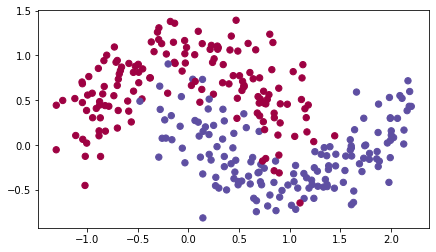

In [9]:
train_X, train_Y = load_dataset()

In [10]:
def model(X, Y, layers_dims, optimizer, learning_rate = 0.0007, mini_batch_size = 64, beta = 0.9,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 5000, print_cost = True):
    """
    3-layer neural network model which can be run in different optimizer modes.
    
    Arguments:
    X -- input data, of shape (2, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    layers_dims -- python list, containing the size of each layer
    learning_rate -- the learning rate, scalar.
    mini_batch_size -- the size of a mini batch
    beta -- Momentum hyperparameter
    beta1 -- Exponential decay hyperparameter for the past gradients estimates 
    beta2 -- Exponential decay hyperparameter for the past squared gradients estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates
    num_epochs -- number of epochs
    print_cost -- True to print the cost every 1000 epochs

    Returns:
    parameters -- python dictionary containing your updated parameters 
    """

    L = len(layers_dims)             # number of layers in the neural networks
    costs = []                       # to keep track of the cost
    t = 0                            # initializing the counter required for Adam update
    seed = 10                        # For grading purposes, so that your "random" minibatches are the same as ours
    m = X.shape[1]                   # number of training examples
    
    # Initialize parameters
    parameters = initialize_parameters(layers_dims)

    # Initialize the optimizer
    if optimizer == "gd":
        pass # no initialization required for gradient descent
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)
    
    # Optimization loop
    for i in range(num_epochs):
        
        # Define the random minibatches. We increment the seed to reshuffle differently the dataset after each epoch
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        cost_total = 0
        
        for minibatch in minibatches:

            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch

            # Forward propagation
            a3, caches = forward_propagation(minibatch_X, parameters)

            # Compute cost and add to the cost total
            cost_total += compute_cost(a3, minibatch_Y)

            # Backward propagation
            grads = backward_propagation(minibatch_X, minibatch_Y, caches)

            # Update parameters
            if optimizer == "gd":
                parameters = update_parameters_with_gd(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adam":
                t = t + 1 # Adam counter
                parameters, v, s, _, _ = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
        cost_avg = cost_total / m
        
        # Print the cost every 1000 epoch
        if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost_avg))
        if print_cost and i % 100 == 0:
            costs.append(cost_avg)
                
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

### Mini-Batch gradient descent

Cost after epoch 0: 0.715794
Cost after epoch 1000: 0.667104
Cost after epoch 2000: 0.645691
Cost after epoch 3000: 0.594800
Cost after epoch 4000: 0.533634


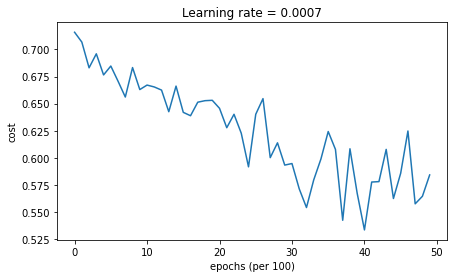

Accuracy: 0.7166666666666667


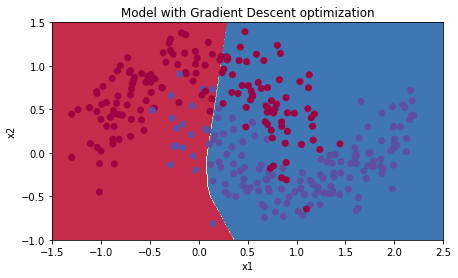

In [13]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "gd")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

### Mini-Batch Gradient Descent with Momentum

Cost after epoch 0: 0.715807
Cost after epoch 1000: 0.667156
Cost after epoch 2000: 0.645751
Cost after epoch 3000: 0.594927
Cost after epoch 4000: 0.533729


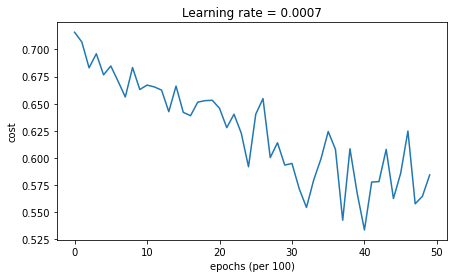

Accuracy: 0.7166666666666667


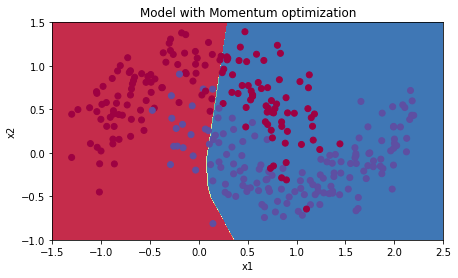

In [15]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, beta = 0.9, optimizer = "momentum")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Momentum optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

### Mini-Batch with Adam

Cost after epoch 0: 0.715208
Cost after epoch 1000: 0.153479
Cost after epoch 2000: 0.161474
Cost after epoch 3000: 0.154778
Cost after epoch 4000: 0.063504


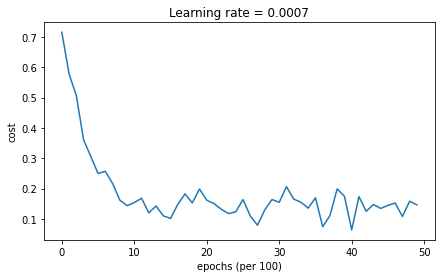

Accuracy: 0.9433333333333334


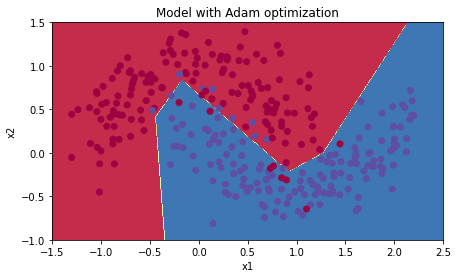

In [16]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "adam")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Adam optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

### Summary

<table> 
    <tr>
        <td>
        <b>optimization method</b>
        </td>
        <td>
        <b>accuracy</b>
        </td>
        <td>
        <b>cost shape</b>
        </td>
    </tr>
        <td>
        Gradient descent
        </td>
        <td>
        >71%
        </td>
        <td>
        smooth
        </td>
    <tr>
        <td>
        Momentum
        </td>
        <td>
        >71%
        </td>
        <td>
        smooth
        </td>
    </tr>
    <tr>
        <td>
        Adam
        </td>
        <td>
        >94%
        </td>
        <td>
        smoother
        </td>
    </tr>
</table> 

Momentum usually helps, but given the small learning rate and the simplistic dataset, its impact is almost negligible.

On the other hand, Adam clearly outperforms mini-batch gradient descent and Momentum. If you run the model for more epochs on this simple dataset, all three methods will lead to very good results. However, you've seen that Adam converges a lot faster.

Some advantages of Adam include:

- Relatively low memory requirements (though higher than gradient descent and gradient descent with momentum) 
- Usually works well even with little tuning of hyperparameters (except $\alpha$)

##  Learning Rate Decay and Scheduling
Lastly, the learning rate is another hyperparameter that can help you speed up learning.

During the first part of training, your model can get away with taking large steps, but over time, using a fixed value for the learning rate alpha can cause your model to get stuck in a wide oscillation that never quite converges. But if you were to slowly reduce your learning rate alpha over time, you could then take smaller, slower steps that bring you closer to the minimum. This is the idea behind learning rate decay.

Learning rate decay can be achieved by using either adaptive methods or pre-defined learning rate schedules.

Now, you'll apply scheduled learning rate decay to a 3-layer neural network in three different optimizer modes and see how each one differs, as well as the effect of scheduling at different epochs.

This model is essentially the same as the one you used before, except in this one you'll be able to include learning rate decay. It includes two new parameters, decay and decay_rate.

In [17]:
def model(X, Y, layers_dims, optimizer, learning_rate = 0.0007, mini_batch_size = 64, beta = 0.9,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 5000, print_cost = True, decay=None, decay_rate=1):
    """
    3-layer neural network model which can be run in different optimizer modes.
    
    Arguments:
    X -- input data, of shape (2, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    layers_dims -- python list, containing the size of each layer
    learning_rate -- the learning rate, scalar.
    mini_batch_size -- the size of a mini batch
    beta -- Momentum hyperparameter
    beta1 -- Exponential decay hyperparameter for the past gradients estimates 
    beta2 -- Exponential decay hyperparameter for the past squared gradients estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates
    num_epochs -- number of epochs
    print_cost -- True to print the cost every 1000 epochs

    Returns:
    parameters -- python dictionary containing your updated parameters 
    """

    L = len(layers_dims)             # number of layers in the neural networks
    costs = []                       # to keep track of the cost
    t = 0                            # initializing the counter required for Adam update
    seed = 10                        # For grading purposes, so that your "random" minibatches are the same as ours
    m = X.shape[1]                   # number of training examples
    lr_rates = []
    learning_rate0 = learning_rate   # the original learning rate
    
    # Initialize parameters
    parameters = initialize_parameters(layers_dims)

    # Initialize the optimizer
    if optimizer == "gd":
        pass # no initialization required for gradient descent
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)
    
    # Optimization loop
    for i in range(num_epochs):
        
        # Define the random minibatches. We increment the seed to reshuffle differently the dataset after each epoch
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        cost_total = 0
        
        for minibatch in minibatches:

            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch

            # Forward propagation
            a3, caches = forward_propagation(minibatch_X, parameters)

            # Compute cost and add to the cost total
            cost_total += compute_cost(a3, minibatch_Y)

            # Backward propagation
            grads = backward_propagation(minibatch_X, minibatch_Y, caches)

            # Update parameters
            if optimizer == "gd":
                parameters = update_parameters_with_gd(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adam":
                t = t + 1 # Adam counter
                parameters, v, s, _, _ = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
        cost_avg = cost_total / m
        if decay:
            learning_rate = decay(learning_rate0, i, decay_rate)
        # Print the cost every 1000 epoch
        if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost_avg))
            if decay:
                print("learning rate after epoch %i: %f"%(i, learning_rate))
        if print_cost and i % 100 == 0:
            costs.append(cost_avg)
                
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

## Decay on every iteration
$$\alpha = \frac{1}{1 + decayRate \times epochNumber} \alpha_{0}$$

In [18]:
def update_lr(learning_rate0, epoch_num, decay_rate):
    """
    Calculates updated the learning rate using exponential weight decay.
    
    Arguments:
    learning_rate0 -- Original learning rate. Scalar
    epoch_num -- Epoch number. Integer
    decay_rate -- Decay rate. Scalar

    Returns:
    learning_rate -- Updated learning rate. Scalar 
    """

    learning_rate = 1 / (1 + np.dot(decay_rate, epoch_num)) * learning_rate0

    return learning_rate

Cost after epoch 0: 0.713477
learning rate after epoch 0: 0.100000
Cost after epoch 1000: 0.662611
learning rate after epoch 1000: 0.000100
Cost after epoch 2000: 0.663391
learning rate after epoch 2000: 0.000050
Cost after epoch 3000: 0.663326
learning rate after epoch 3000: 0.000033
Cost after epoch 4000: 0.631569
learning rate after epoch 4000: 0.000025


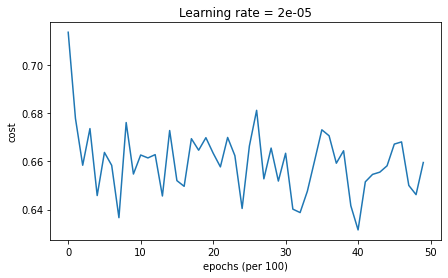

Accuracy: 0.6566666666666666


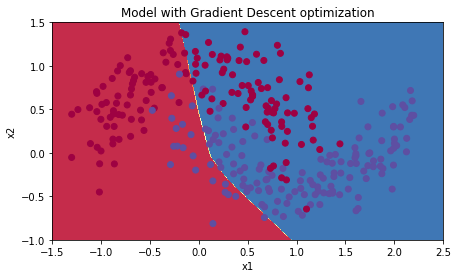

In [19]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "gd", learning_rate = 0.1, num_epochs=5000, decay=update_lr)

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

## Fixed Interval Scheduling
You can help prevent the learning rate speeding to zero too quickly by scheduling the exponential learning rate decay at a fixed time interval, for example 1000. You can either number the intervals, or divide the epoch by the time interval, which is the size of window with the constant learning rate. 

$$\alpha = \frac{1}{1 + decayRate \times \frac{epochNum}{timeInterval}} \alpha_{0}$$

In [20]:
def schedule_lr_decay(learning_rate, epoch_num, decay_rate, time_interval=1000):
    """
    Calculates updated the learning rate using exponential weight decay.
    
    Arguments:
    learning_rate -- Original learning rate. Scalar
    epoch_num -- Epoch number. Integer.
    decay_rate -- Decay rate. Scalar.
    time_interval -- Number of epochs where you update the learning rate.

    Returns:
    learning_rate -- Updated learning rate. Scalar 
    """

    if (epoch_num % time_interval) == 0:
        learning_rate = 1 / (1 + decay_rate * (epoch_num / time_interval)) * learning_rate

    return learning_rate

## Using Learning Rate Decay for each Optimization Method

### Gradient Descent with Learning Rate Decay

Cost after epoch 0: 0.713477
learning rate after epoch 0: 0.100000
Cost after epoch 1000: 0.111601
learning rate after epoch 1000: 0.050000
Cost after epoch 2000: 0.119826
learning rate after epoch 2000: 0.033333
Cost after epoch 3000: 0.099753
learning rate after epoch 3000: 0.025000
Cost after epoch 4000: 0.056559
learning rate after epoch 4000: 0.020000


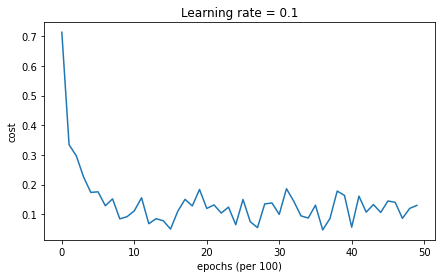

Accuracy: 0.9466666666666667


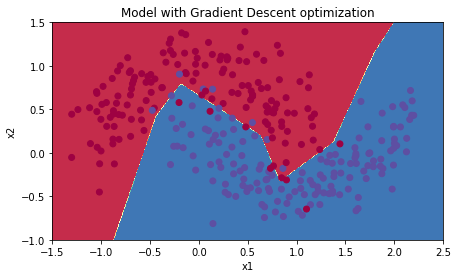

In [21]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "gd", learning_rate = 0.1, num_epochs=5000, decay=schedule_lr_decay)

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

### Gradient Descent with Momentum and Learning Rate Decay

Cost after epoch 0: 0.715386
learning rate after epoch 0: 0.100000
Cost after epoch 1000: 0.110155
learning rate after epoch 1000: 0.050000
Cost after epoch 2000: 0.140728
learning rate after epoch 2000: 0.033333
Cost after epoch 3000: 0.101094
learning rate after epoch 3000: 0.025000
Cost after epoch 4000: 0.079807
learning rate after epoch 4000: 0.020000


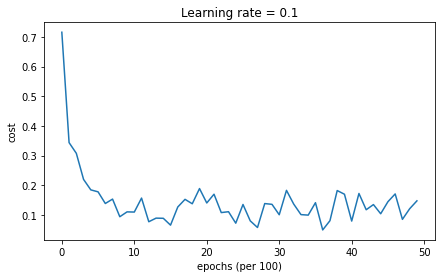

Accuracy: 0.9466666666666667


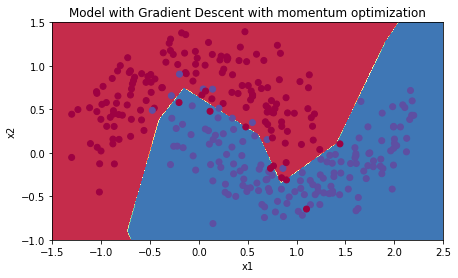

In [22]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "momentum", learning_rate = 0.1, num_epochs=5000, decay=schedule_lr_decay)

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Gradient Descent with momentum optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

### Adam with Learning Rate Decay

Cost after epoch 0: 0.707915
learning rate after epoch 0: 0.010000
Cost after epoch 1000: 0.118096
learning rate after epoch 1000: 0.005000
Cost after epoch 2000: 0.192968
learning rate after epoch 2000: 0.003333
Cost after epoch 3000: 0.117879
learning rate after epoch 3000: 0.002500
Cost after epoch 4000: 0.061932
learning rate after epoch 4000: 0.002000


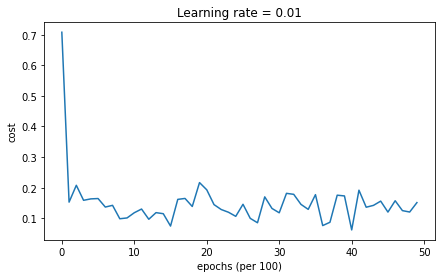

Accuracy: 0.94


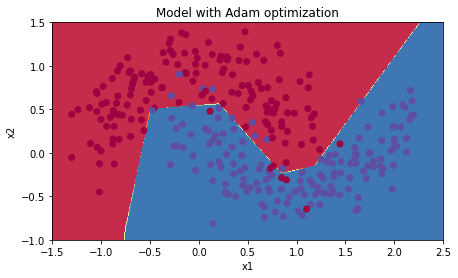

In [23]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "adam", learning_rate = 0.01, num_epochs=5000, decay=schedule_lr_decay)

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Adam optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

### Achieving similar performance with different methods

With SGD or SGD with Momentum, the accuracy is significantly lower than Adam, but when learning rate decay is added on top, either can achieve performance at a speed and accuracy score that's similar to Adam.

In the case of Adam, notice that the learning curve achieves a similar accuracy but faster.

<table> 
    <tr>
        <td>
        <b>optimization method</b>
        </td>
        <td>
        <b>accuracy</b>
        </td>
    </tr>
        <td>
        Gradient descent
        </td>
        <td>
        >94.6%
        </td>
    <tr>
        <td>
        Momentum
        </td>
        <td>
        >94.6%
        </td>
    </tr>
    <tr>
        <td>
        Adam
        </td>
        <td>
        94%
        </td>
    </tr>
</table> 